In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 2000)
ds_salaries = pd.read_csv('../../csvs/ds_salaries.csv')
ds_salaries.head()


,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Data Cleaning

In [42]:
print('Number of rows: ',ds_salaries.shape[0])
print(ds_salaries.info())

Number of rows:  607
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB
None


We can see that there are no Null/NaN values in a dataset.</br>
We can further investigate two things:
1. Usefulness of 'Unnamed:0' column
2. What columns can we turn into categories

We'll start with the first point.</br>
If it has same values as our index column, then there is no point to it

In [43]:
if (ds_salaries['Unnamed: 0']==ds_salaries.index).all():
    print('Index matches "Unnamed: 0" column.')
    ds_salaries = ds_salaries.drop(columns=['Unnamed: 0'])
else:
    print('Index does not match "Unnamed: 0" column.')

ds_salaries.head()

Index matches "Unnamed: 0" column.


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Data Preprocessing

Proceeding with the second point. We can already convert to categories, because they have fixed, predictable values. 
- experience_level
- employment_type
- company_size
- remote_ratio</br>

We could also add new columns with categories, based on these already existing column by providing conditions:
- employee_residence - we could add a employee_continent column
- company_location - we could add a company_continent column
- <p style='max-width:70ch'>job_title - we could use string functions with conditions, to divide jobs into categories, such as data sience/ML/Data engeniere/Big Data</p>



In [44]:
ds_salaries['experience_level']=ds_salaries['experience_level'].astype('category')
ds_salaries['employment_type']=ds_salaries['employment_type'].astype('category')
ds_salaries['company_size']=ds_salaries['company_size'].astype('category')

In [45]:
# First we create a list of labels for remote work categories
remote_labels = ['Remote', 'Hybrid', 'Onsite']

# Then we create conditions based on the 'remote_ratio' column
conditions = [
    ds_salaries['remote_ratio'] == 100,
    (ds_salaries['remote_ratio'] > 0) & (ds_salaries['remote_ratio'] < 100),
    ds_salaries['remote_ratio'] == 0
]
# We use np.select to assign the labels based on the conditions
ds_salaries['remote']= np.select(conditions,remote_labels,default='Unknown')

# Convert the 'remote' column to a categorical type
ds_salaries['remote'] = ds_salaries['remote'].astype('category')

### Continent column

Adding continent column requires a few things:
1. Identify country codes
2. Get continents for country codes and put them in a dict
3. Map values from this dictionary to our new columns

In [46]:
country_codes = pd.concat([ds_salaries['company_location'],ds_salaries['employee_residence']]).unique()
# First step done


def get_continent_from_api (country_code):
    try:
        url = f'https://restcountries.com/v3.1/alpha/{country_code}'
        r = requests.get(url)
        if r.status_code==200:
            data=r.json()[0]
            return data.get('region','Unknown')
        else: 
            return 'Unknown'
    except:
        return 'Unknown'

code_to_continent={}
for code in country_codes:
    continent = get_continent_from_api(code)
    code_to_continent[code]=continent
    time.sleep(0.5)
    print(f"{code}:{continent}")

DE:Europe
JP:Asia
GB:Europe
HN:Americas
US:Americas
HU:Europe
NZ:Oceania
FR:Europe
IN:Asia
PK:Asia
CN:Asia
GR:Europe
AE:Asia
NL:Europe
MX:Americas
CA:Americas
AT:Europe
NG:Africa
ES:Europe
PT:Europe
DK:Europe
IT:Europe
HR:Europe
LU:Europe
PL:Europe
SG:Asia
RO:Europe
IQ:Asia
BR:Americas
BE:Europe
UA:Europe
IL:Asia
RU:Europe
MT:Europe
CL:Americas
IR:Asia
CO:Americas
MD:Europe
KE:Africa
SI:Europe
CH:Europe
VN:Asia
AS:Oceania
TR:Asia
CZ:Europe
DZ:Africa
EE:Europe
MY:Asia
AU:Oceania
IE:Europe
PH:Asia
BG:Europe
HK:Asia
RS:Europe
PR:Americas
JE:Europe
AR:Americas
TN:Africa
BO:Americas


In [47]:
ds_salaries['employee_continent']=ds_salaries['employee_residence'].map(code_to_continent)
ds_salaries['company_continent']=ds_salaries['company_location'].map(code_to_continent)
print(ds_salaries.head())
print(f"Missing continent mappings: {ds_salaries['employee_continent'].isna().sum()}")

   work_year experience_level employment_type                   job_title  salary salary_currency  salary_in_usd employee_residence  remote_ratio company_location company_size  remote employee_continent company_continent
0       2020               MI              FT              Data Scientist   70000             EUR          79833                 DE             0               DE            L  Onsite             Europe            Europe
1       2020               SE              FT  Machine Learning Scientist  260000             USD         260000                 JP             0               JP            S  Onsite               Asia              Asia
2       2020               SE              FT           Big Data Engineer   85000             GBP         109024                 GB            50               GB            M  Hybrid             Europe            Europe
3       2020               MI              FT        Product Data Analyst   20000             USD          20000    

### Job description

First we need to decide what columns we have and what categories we could creates

In [48]:
ds_salaries['job_title'].value_counts(ascending=False)
# ds_salaries['job_title'].unique()

job_title
Data Scientist                              143
Data Engineer                               132
Data Analyst                                 97
Machine Learning Engineer                    41
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Machine Learning Scientist                    8
Big Data Engineer                             8
Director of Data Science                      7
AI Scientist                                  7
Principal Data Scientist                      7
Data Science Consultant                       7
Data Analytics Manager                        7
BI Data Analyst                               6
Computer Vision Engineer                      6
ML Engineer                                   6
Lead Data Engineer                            6
Applied Data Scientist                        5
Business Data Analyst                         5
Data Engineering Manager      

**We can create further categories**
1. Machine Learning & AI Engineering </br>
     <p style='max-width:70ch'><b>Keywords</b>:
     AI|ML|Computer Vision|CV|NLP|Natural Language Processing|Learning|MLOps|Neural Networks
     </p>

2. Data Science & Research </br>
     <p style='max-width:70ch'><b>Keywords</b>:
     Data Science|Scientist|Research|Statistical|Statistic|Predictive Analytics|Experimentation|Quantitative Analysis|Forecasting|Optimization
     </p>

3. Data Engineering & Architecture </br>
     <p style='max-width:70ch'><b>Keywords</b>:
     Data Engineer|ETL|Data Pipeline|Architecture|Big Data|Cloud|Warehouse|Lake|Database|Distributed Systems|Infrastructure
     </p>
4. Data Analysis & Business Intelligence </br>
     <p style='max-width:70ch'><b>Keywords</b>:
     Analyst|Analytics|Business Intelligence|BI|Reporting|Dashboard|Visualization|Performance|Financial|Product|Marketing
     </p>
5. Data Leadership & Management </br>
     <p style='max-width:70ch'><b>Keywords</b>: 
     Director|Head|Manager|Lead|Principal|Chief Data Officer|CDO|Strategy|Team Leadership
     </p>
6. Uncategorized 

In [49]:
ml_ai_string = "AI|ML|Computer Vision|CV|NLP|Natural Language Processing|Learning|MLOps|Neural Networks"
data_science_string = "Science|Scientist|Research|Statistical|Statistic|Predictive Analytics|Experimentation|Quantitative Analysis|Forecasting|Optimization"
data_engineer_string = "Engineer|ETL|Pipeline|Architecture|Big Data|Cloud|Warehouse|Lake|Database|Distributed Systems|Infrastructure"
data_analysis_string = "Analyst|Analytics|Business Intelligence|BI|Reporting|Dashboard|Visualization|Performance|Financial|Product|Marketing"
data_leadership_string = "Director|Head|Manager|Lead|Principal|Chief Data Officer|CDO|Strategy|Team Leadership"

job_categories = [
    "ML/AI",
    "Data Science",
    "Data Engineer",
    "Data Analysis",
    "Data Leadership",
]

conditions = [
    (ds_salaries["job_title"].str.contains(ml_ai_string)),
    (ds_salaries["job_title"].str.contains(data_science_string)),
    (ds_salaries["job_title"].str.contains(data_engineer_string)),
    (ds_salaries["job_title"].str.contains(data_analysis_string)),
    (ds_salaries["job_title"].str.contains(data_leadership_string)),
]

ds_salaries["job_category"] = np.select(
    conditions, job_categories, default="Uncategorized"
)
ds_salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote,employee_continent,company_continent,job_category
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,Onsite,Europe,Europe,Data Science
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,Onsite,Asia,Asia,ML/AI
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,Hybrid,Europe,Europe,Data Engineer
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,Onsite,Americas,Americas,Data Analysis
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,Hybrid,Americas,Americas,ML/AI


After adding job categories, we should look at the general numbers

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Data Science'),
  Text(1, 0, 'ML/AI'),
  Text(2, 0, 'Data Engineer'),
  Text(3, 0, 'Data Analysis'),
  Text(4, 0, 'Data Leadership'),
  Text(5, 0, 'Uncategorized')])

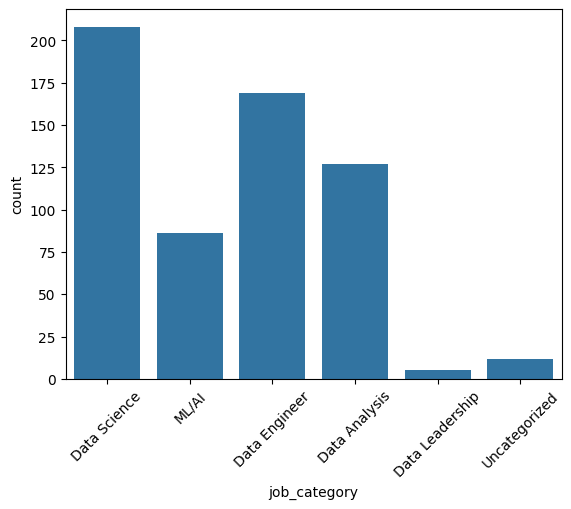

In [50]:
sns.countplot(data=ds_salaries, x="job_category")
plt.xticks(rotation=45)

We have a lot of uncategorized job titles, it's worth looking into them, and maybe adding more keywords

In [51]:
print(ds_salaries[ds_salaries["job_category"] == "Uncategorized"])

     work_year experience_level employment_type        job_title  salary salary_currency  salary_in_usd employee_residence  remote_ratio company_location company_size  remote employee_continent company_continent   job_category
165       2021               SE              FT  Data Specialist  165000             USD         165000                 US           100               US            L  Remote           Americas          Americas  Uncategorized
169       2021               MI              FT   Data Architect  150000             USD         150000                 US           100               US            L  Remote           Americas          Americas  Uncategorized
170       2021               MI              FT   Data Architect  170000             USD         170000                 US           100               US            L  Remote           Americas          Americas  Uncategorized
234       2021               MI              FT   Data Architect  180000             USD    

We can see that only data architects and specialists got here, so we should add them to the list
- Data architect - data engineering & architecture
- Data Specialist - analysis and data management

In [52]:
data_engineer_string = data_engineer_string + "|Architect"
data_analysis_string = data_analysis_string + "|Specialist"

#! Redifine the conditions list
conditions = [
    (ds_salaries["job_title"].str.contains(ml_ai_string)),
    (ds_salaries["job_title"].str.contains(data_science_string)),
    (ds_salaries["job_title"].str.contains(data_engineer_string)),
    (ds_salaries["job_title"].str.contains(data_analysis_string)),
    (ds_salaries["job_title"].str.contains(data_leadership_string)),
]

ds_salaries["job_category"] = np.select(
    conditions, job_categories, default="Uncategorized"
)


print(ds_salaries[ds_salaries["job_category"] == "Uncategorized"])

Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, salary, salary_currency, salary_in_usd, employee_residence, remote_ratio, company_location, company_size, remote, employee_continent, company_continent, job_category]
Index: []


## Data Exploration

<Figure size 500x500 with 0 Axes>

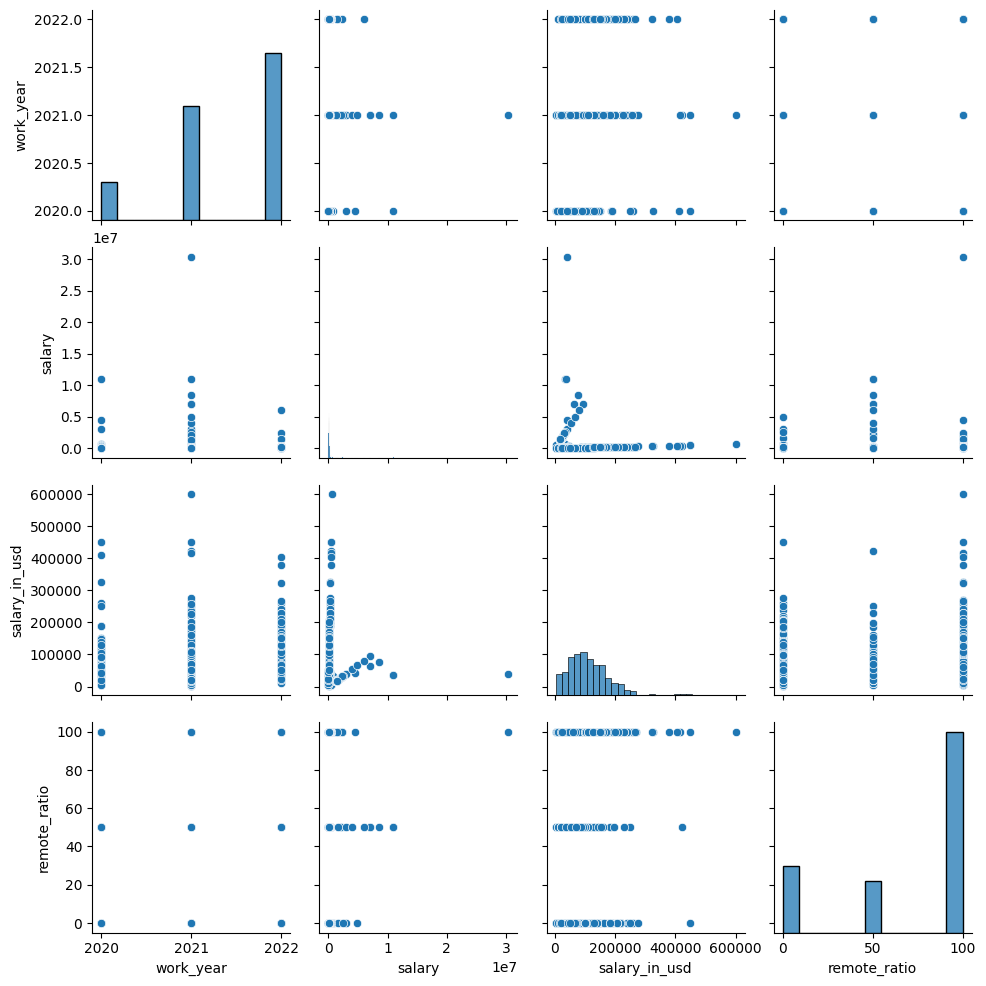

In [53]:
plt.figure(figsize=(5,5))
sns.pairplot(ds_salaries)

pairplot did not show many interesting correlations.
But it's worth exploring the dataframe manualy

My first few hypotheses are:
- Salary is highly dependent on job category
- Salary is highly dependent on remote type
- Salary is highly dependent on employer continent
- Salary is highly dependent on expirience
- Salary might depend on employment type

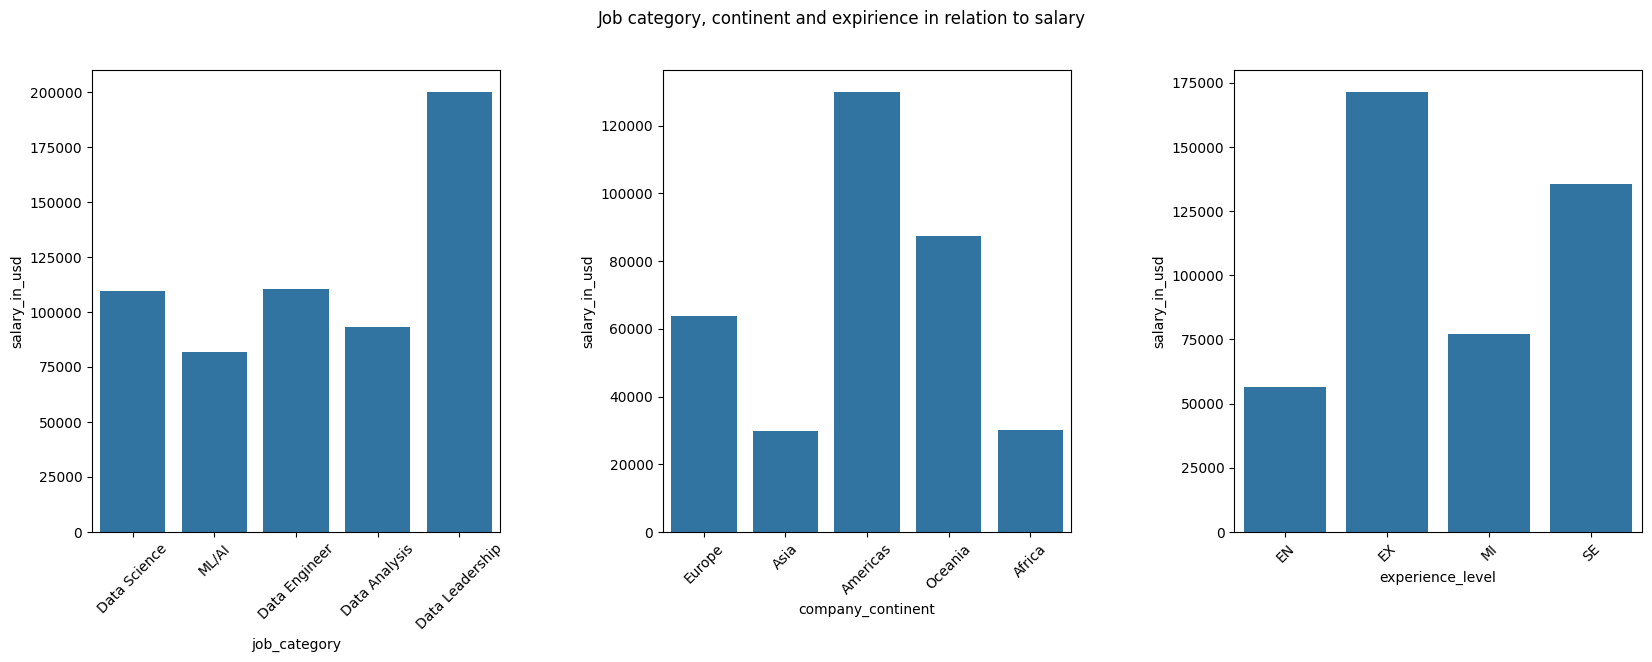

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Job category, continent and expirience in relation to salary')

sns.barplot(
    data=ds_salaries,
    x="job_category",
    y="salary_in_usd",
    ax=axes[0],
    estimator="median",
    errorbar=None,
)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(
    data=ds_salaries,
    x="company_continent",
    y="salary_in_usd",
    ax=axes[1],
    estimator="median",
    errorbar=None,
)
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(
    data=ds_salaries,
    x="experience_level",
    y="salary_in_usd",
    ax=axes[2],
    estimator="median",
    errorbar=None,
)
axes[2].tick_params(axis='x', rotation=45)
plt.subplots_adjust(wspace=0.4,hspace=0.4)

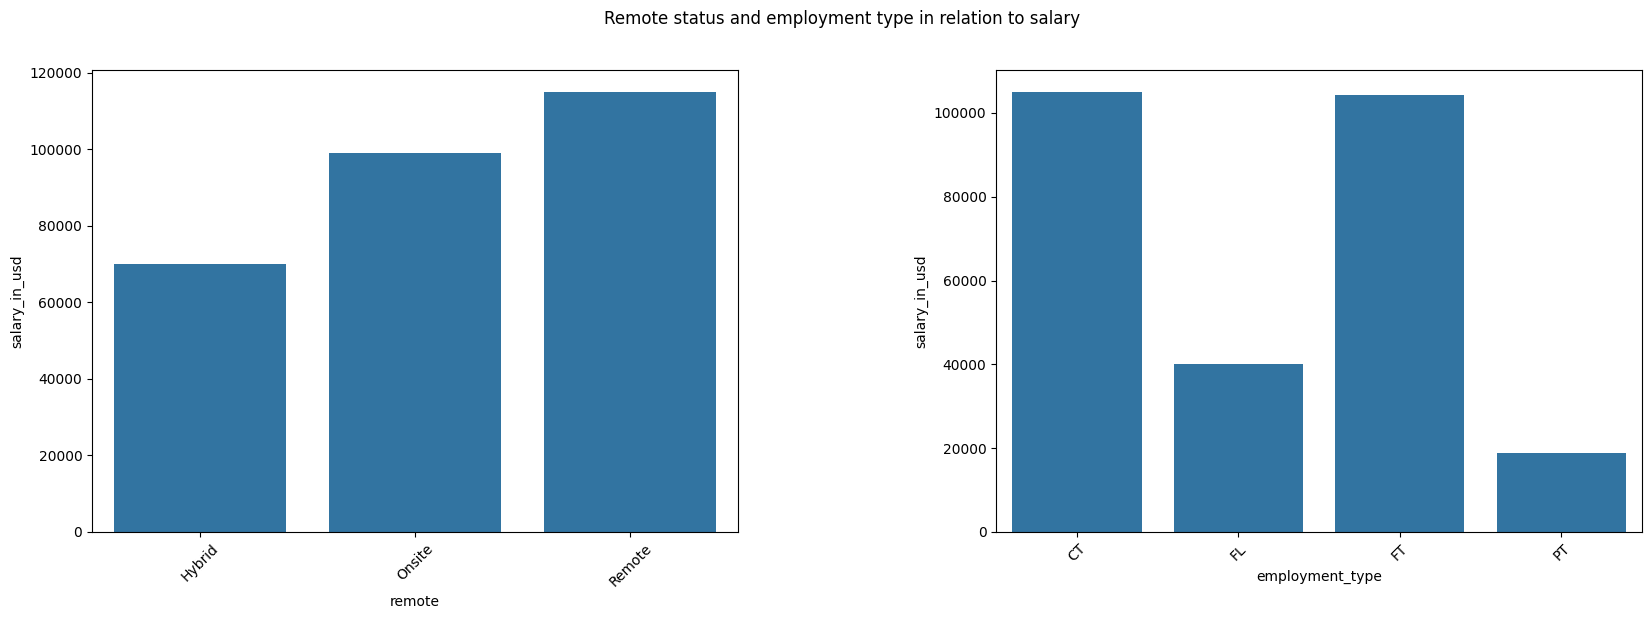

In [55]:
fig,axes = plt.subplots(1,2, figsize=(20,6))
fig.suptitle('Remote status and employment type in relation to salary')

sns.barplot(
    data=ds_salaries,
    x="remote",
    y="salary_in_usd",
    ax=axes[0],
    estimator="median",
    errorbar=None,
)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(
    data=ds_salaries,
    x="employment_type",
    y="salary_in_usd",
    ax=axes[1],
    estimator="median",
    errorbar=None,
)
axes[1].tick_params(axis='x', rotation=45)

plt.subplots_adjust(wspace=0.4,hspace=0.4)

We can conclude that almost all hypotheses hold true, with minor adjustments:
- Salary seems to be equal, for all job categories, but is significantly higher for leadership roles
- Salary is more dependent on employment type then expected


## Export

In [57]:
ds_salaries.to_csv('ds_salaries_2.csv', index=False)


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
ds_salaries = pd.read_csv('ds_salaries_2.csv')


In [62]:
def export_to_postgres_sql(df, table_name, filename):
    """Export DataFrame to PostgreSQL SQL file"""
    
    # Map pandas dtypes to PostgreSQL types
    def get_postgres_type(dtype, col_name):
        if dtype == 'object':
            return 'VARCHAR(255)'
        elif dtype == 'int64':
            return 'INTEGER'
        elif dtype == 'float64':
            return 'DECIMAL(10,2)'
        elif dtype == 'category':
            return 'VARCHAR(100)'
        else:
            return 'VARCHAR(255)'
    
    sql_content = []
    
    # CREATE TABLE statement
    sql_content.append(f"-- PostgreSQL export for {table_name}")
    sql_content.append(f"DROP TABLE IF EXISTS {table_name};")
    sql_content.append(f"CREATE TABLE {table_name} (")
    
    columns = []
    for col in df.columns:
        postgres_type = get_postgres_type(df[col].dtype, col)
        columns.append(f"    {col} {postgres_type}")
    
    sql_content.append(",\n".join(columns))
    sql_content.append(");")
    sql_content.append("")
    
    # INSERT statements
    sql_content.append(f"-- Insert data into {table_name}")
    
    for _, row in df.iterrows():
        values = []
        for val in row:
            if pd.isna(val):
                values.append("NULL")
            elif isinstance(val, str):
                # Escape single quotes for PostgreSQL
                escaped_val = val.replace("'", "''")
                values.append(f"'{escaped_val}'")
            else:
                values.append(str(val))
        
        insert_stmt = f"INSERT INTO {table_name} VALUES ({', '.join(values)});"
        sql_content.append(insert_stmt)
    
    # Write to file
    with open(filename, 'w', encoding='utf-8') as f:
        f.write('\n'.join(sql_content))
    
    print(f"PostgreSQL SQL file created: {filename}")

# Export your processed data
export_to_postgres_sql(ds_salaries, 'ds_salaries', 'ds_salaries_postgres.sql')

PostgreSQL SQL file created: ds_salaries_postgres.sql
